In [1]:
import numpy as np
import torch
import pandas as pd
import odbo
import os

## Get initial experiment design (temp using 2016 data, change to other experiments later)

In [2]:
# Load dataset
random_seed = 100
np.random.seed(random_seed)
data_test = pd.read_csv('../datasets/GB1_2016_149361.csv', sep=',')
name_pre, Y_test = np.array(data_test['AACombo']), np.array(data_test['Fitness'])
shuffle_order = np.arange(len(Y_test))
np.random.shuffle(shuffle_order[1:])
name_pre[1:], Y_test[1:] = name_pre[shuffle_order[1:]], Y_test[shuffle_order[1:]]
name = odbo.utils.code_to_array(name_pre)
if os.path.isfile('sele_experiment_GB1_2016.npy') == True:
    name_sele = np.load('sele_experiment_GB1_2016.npy')
    Y_train = np.load('sele_fitness_GB1_2016.npy')
    print('Selected initial experiments no. is ', len(Y_train))
else:
    # Let each site has 20 AA codes at least show up twice 
    sele_indices = odbo.initialization.initial_design(name, least_occurance=[2,2,2,2],verbose = False,random_state=random_seed)
    # Initial experiments are selected to be name_sele with fitness of Y_sele
    name_sele, Y_train = name[sele_indices, :], Y_test[sele_indices]
    print('Selected initial experiments no. is ', len(sele_indices))
print('Select max Y: ', Y_train.max())

Selected initial experiments no. is  40
Select max Y:  1.320616068


## Transform AA codes to average fitness feature 

In [3]:
# Using average measurement results as features
threshold = max(0.05, np.mean(Y_train)-2*np.std(Y_train))
feature_model = odbo.featurization.AvgMeasurement(raw_vars=name_sele, Y=Y_train)
X_train = feature_model.transform(name_sele)
X_test = feature_model.transform(name)

## Adapt search space construction

In [4]:
# Find the adaptive search space model
labels_train = odbo.prescreening.sp_label(X_train, Y_train, thres=threshold)
pre_model = odbo.prescreening.XGBOD(eval_metric = 'error')
pre_model.fit(X_train, labels_train)
pred_labels = pre_model.predict(X_train)
labels_test = odbo.prescreening.sp_label(X_test, Y_test, thres=threshold)
pred_test_labels = pre_model.predict(X_test)

/usr/local/lib/python3.7/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")
/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:49:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Correct ratio: 90.467%
FN ratio: 0.222%
FP ratio: 9.312%


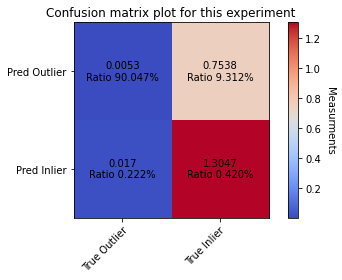

In [5]:
# Plot the confusion matrix to check the accuracy of search space prescreening
out_outlier, in_outlier, out_inlier, in_inlier = odbo.plot.plot_cm(labels_test, pred_test_labels, Y_test)
print("Correct ratio: {0:.3%}".format((len(out_outlier)+len(in_inlier))/len(labels_test)))
print("FN ratio: {0:.3%}".format(len(out_inlier)/len(labels_test)))
print("FP ratio: {0:.3%}".format(len(in_outlier)/len(labels_test)))  

## BO for next best experiment

In [6]:
X_train_sele, Y_train_sele = torch.tensor(X_train), torch.tensor(Y_train.reshape(len(Y_train),1))
# Only search the space after prescreening
sele_id_test = list(np.array([k for k, x in enumerate(pred_test_labels) if x == 0]))
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
search_name_sele, name_sele_temp = name[sele_id_test, :], name_sele

## Run BO experiment with robust regression or directly gp
l, search_iter = 0, 50
batch_size = 1
gp_method='robust_regression'
failure_count,max_count = 0, 0
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), "True max: ",Y_test_sele.max().detach().numpy())
    X_next, acq_value, next_exp_id = odbo.bo_design(X=X_train_sele, Y=Y_train_sele, X_pending=X_test_sele, gp_method=gp_method, batch_size=batch_size)
    ids_keep = list(np.delete(range(X_test_sele.shape[0]), next_exp_id))
    X_train_sele, Y_train_sele = torch.cat([X_train_sele, X_test_sele[next_exp_id, :]]), torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    X_test_sele, Y_test_sele, search_name_sele = X_test_sele[ids_keep, :], Y_test_sele[ids_keep], search_name_sele[ids_keep]
    name_sele_temp = np.concatenate((name_sele_temp, search_name_sele[next_exp_id]))
    print("Newly added experiment: ", Y_train_sele[-batch_size:].detach().numpy(), search_name_sele[next_exp_id])
    feature_model1 = odbo.featurization.AvgMeasurement(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy())
    if Y_train_sele[-batch_size:].detach().numpy().max() <= Y_train_sele[:-batch_size].max():
        failure_count = failure_count + 1
    else:
        failure_count = 0
    if failure_count >= 3 and max_count < 3:
        max_count = max_count + 1
        feature_model1 = odbo.featurization.MaxMeasurement(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy())
    else:
        max_count = 0
    X_train_sele = torch.tensor(feature_model1.transform(X_train_sele))
    X_test_sele= torch.tensor(feature_model1.transform(X_test_sele))
    l = l + 1



Iter:  0 Current Max:  1.320616068 True max:  8.761965656
2  outliers found
Newly added experiment:  [[0.02815925]] [['V' 'A' 'A' 'A']]
Iter:  1 Current Max:  1.320616068 True max:  8.761965656
2  outliers found
Newly added experiment:  [[0.05086082]] [['V' 'K' 'M' 'C']]
Iter:  2 Current Max:  1.320616068 True max:  8.761965656
3  outliers found
Newly added experiment:  [[0.279565]] [['F' 'M' 'A' 'A']]
Iter:  3 Current Max:  1.320616068 True max:  8.761965656
2  outliers found
Newly added experiment:  [[0.20959314]] [['F' 'G' 'A' 'M']]
Iter:  4 Current Max:  1.320616068 True max:  8.761965656
2  outliers found
Newly added experiment:  [[0.04253017]] [['F' 'W' 'G' 'A']]
Iter:  5 Current Max:  1.320616068 True max:  8.761965656
2  outliers found
Newly added experiment:  [[0.16250959]] [['Q' 'T' 'G' 'C']]
Iter:  6 Current Max:  1.320616068 True max:  8.761965656
2  outliers found
Newly added experiment:  [[1.34186633]] [['Q' 'V' 'L' 'A']]
Iter:  7 Current Max:  1.341866327 True max:  8.76

/usr/local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Iter 10/500: 1.4648588269929421
Iter 20/500: 1.3118119135002952
Iter 30/500: 1.1268449738870194
Iter 40/500: 1.075066786689678
Iter 50/500: 1.0618617312087386
Iter 60/500: 1.0512788837701523
Iter 70/500: 1.0367771714564242
Iter 80/500: 0.05212370299933987
Iter 90/500: -0.17567552264881334
Iter 100/500: -0.18749966615186378
Iter 110/500: -0.20995716435785566
Iter 120/500: -0.21173614795315987
Iter 130/500: -0.21334387868964066
Iter 140/500: -0.213894992988795
Iter 150/500: -0.2140000113126108
Iter 160/500: -0.21411345947817842
The scipy optimizer and minimum inferred noises cannot make the kernel PSD, switch to torch optimizer
Newly added experiment:  [[1.76126924]] [['Q' 'M' 'L' 'C']]
Iter:  8 Current Max:  1.76126924 True max:  8.761965656
4  outliers found
Newly added experiment:  [[0.15218225]] [['Q' 'R' 'G' 'V']]
Iter:  9 Current Max:  1.76126924 True max:  8.761965656
4  outliers found
Newly added experiment:  [[0.00113258]] [['V' 'K' 'A' 'C']]
Iter:  10 Current Max:  1.76126924 T

## TurBO for next best experiment

In [9]:
X_train_sele, Y_train_sele = torch.tensor(X_train), torch.tensor(Y_train.reshape(len(Y_train),1))
# Only search the space after prescreening
sele_id_test = []
sele_id_test.extend(in_inlier)
sele_id_test.extend(out_inlier)
search_name_sele, name_sele_temp = name[sele_id_test, :], name_sele
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))

# Run BO experiment with robust regression or directly gp
l, search_iter = 0, 50
gp_method='gp_regression'
tr_length = [4.8]
batch_size = 1
failure_count = 0

state = odbo.turbo.TurboState(dim=X_train_sele.shape[1], batch_size=batch_size, length=tr_length, n_trust_regions=len(tr_length), failure_tolerance = 10)
state.best_value = Y_train_sele.max()
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), 'TR length: ', state.length, 'True max ', Y_test_sele.max())
    X_next, acq_value, raw_next_exp_id = odbo.turbo_design(state=state, X=X_train_sele, Y=Y_train_sele, X_pending=X_test_sele, n_trust_regions=len(tr_length), batch_size=batch_size, gp_method=gp_method)
    Y_next_m = torch.zeros((len(tr_length), batch_size, 1), device=Y_train_sele.device, dtype=Y_train_sele.dtype)
    next_exp_id = []
    for i in range(batch_size):
        next_exp_id_m = raw_next_exp_id[:, i]
        Y_next_m[:, i, 0], idtoadd = Y_test_sele[next_exp_id_m].reshape(len(tr_length)), next_exp_id_m[np.argmax(Y_test_sele[next_exp_id_m])]
        next_exp_id.append(idtoadd)
    X_train_sele, Y_train_sele = torch.cat([X_train_sele, X_test_sele[next_exp_id, :]]), torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    ids_keep = list(np.delete(range(X_test_sele.shape[0]), next_exp_id))
    X_test_sele, Y_test_sele, search_name_sele = X_test_sele[ids_keep, :], Y_test_sele[ids_keep], search_name_sele[ids_keep]
    name_sele_temp = np.concatenate((name_sele_temp, search_name_sele[next_exp_id]))
    print("Newly added experiment: ", Y_train_sele[-batch_size:].detach().numpy(), search_name_sele[next_exp_id])
    state = odbo.turbo.update_state(state=state, Y_next=Y_next_m)
    feature_model1 = odbo.featurization.AvgMeasurement(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy())
    if Y_train_sele[-batch_size:].detach().numpy().max() <= Y_train_sele[:-batch_size].max():
        failure_count = failure_count + 1
    else:
        failure_count = 0
    if failure_count >= 3 and max_count < 3:
        max_count = max_count + 1
        feature_model1 = odbo.featurization.MaxMeasurement(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy())
    else:
        max_count = 0
    X_train_sele = torch.tensor(feature_model1.transform(X_train_sele))
    X_test_sele= torch.tensor(feature_model1.transform(X_test_sele))

    l = l + 1



Iter:  0 Current Max:  1.320616068 TR length:  [4.8] True max  tensor(8.7620, dtype=torch.float64)
Newly added experiment:  [[0.00384758]] [['V' 'Q' 'M' 'V']]
Iter:  1 Current Max:  1.320616068 TR length:  [4.8] True max  tensor(8.7620, dtype=torch.float64)
Newly added experiment:  [[0.01078996]] [['V' 'W' 'L' 'V']]
Iter:  2 Current Max:  1.320616068 TR length:  [4.8] True max  tensor(8.7620, dtype=torch.float64)
Newly added experiment:  [[0.66989285]] [['V' 'Q' 'L' 'A']]
Iter:  3 Current Max:  1.320616068 TR length:  [4.8] True max  tensor(8.7620, dtype=torch.float64)
Newly added experiment:  [[0.31354108]] [['Q' 'D' 'G' 'M']]
Iter:  4 Current Max:  1.320616068 TR length:  [4.8] True max  tensor(8.7620, dtype=torch.float64)
Newly added experiment:  [[4.50273083]] [['V' 'Y' 'G' 'M']]
Iter:  5 Current Max:  4.502730826 TR length:  [4.8] True max  tensor(8.7620, dtype=torch.float64)
Newly added experiment:  [[4.15798313]] [['V' 'C' 'G' 'A']]
Iter:  6 Current Max:  4.502730826 TR length: 

/usr/local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Iter 10/500: 1.4357896259386964
Iter 20/500: 1.2961396104367564
Iter 30/500: 1.0723547201594832
Iter 40/500: 0.8558466453743261
The scipy optimizer and minimum inferred noises cannot make the kernel PSD, switch to torch optimizer
Newly added experiment:  [[0.17319376]] [['Q' 'L' 'A' 'A']]
